### Model 1 - level 1 codes; base of dx and pcs

    Step 1 : Read the processed files pat_adm(latest encounter), pat_med(medications),diagnoses_rbase,procedures_rbase,labs
    Step 2: Join pat_adm (required_columns) with diagnoses_rbase and do OHE
    Step 3: Join pat_adm (required_columns) with procedures_rbase and do OHE    
    Step 4: If more than 95% is missing , drop the column  for each df
    Step 5: Medications - OHE; again if more than 95% missing, drop the columns
    Step 6:Add labs, add demographics data, Add target variable - increase_flag    

### Model 1 - level 2 codes; granular

    Step 1 : Read the files pat_adm(latest encounter), pat_med(medications),diagnoses_r,procedures_r,labs
    Step 2: Join pat_adm (required_columns) with diagnoses_rbase and do OHE
    Step 3: Join pat_adm (required_columns) with procedures_rbase and do OHE    
    Step 4: If more than 95% is missing , drop the column  for each df
    Step 5: Medications - OHE; again if more than 95% missing, drop the columns
    Step 6:Add labs, add demographics data, Add target variable - increase_flag 

In [1]:
import pandas as pd
#!pip install imblearn
#!pip install scikit-learn==1.2.2
# check version number
import imblearn
from imblearn.under_sampling import RandomUnderSampler
from datetime import timedelta
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
#!pip install numpy
#import shap
hosp='W:\\Main_project\\mimic-iv-2.2\\mimic-iv-2.2\\hosp\\'
icu='W:\\Main_project\\mimic-iv-2.2\\mimic-iv-2.2\\icu\\'
base='W:\\Main_project\\base_files\\'
#!pip install shap

In [2]:
pat_adm=pd.read_csv(f'{base}pat_adm_aki_time_final.csv')

In [3]:
#Categorize the race

prefix_mapping = {
    'WHITE': 'White',
    'BLACK': 'Black',
    'UNKNOWN': 'Unknown',
    'HISPANIC/LATINO': 'Hispanic/Latino',
    'HISPANIC OR LATINO': 'Hispanic/Latino',
    'ASIAN': 'Asian'
}

# Update the values in the 'race' column
for prefix, new_name in prefix_mapping.items():
    pat_adm.loc[pat_adm['race'].str.startswith(prefix), 'race'] = new_name
print(pat_adm['race'].unique())    

['Black' 'Unknown' 'White' 'Asian' 'Hispanic/Latino' 'OTHER'
 'UNABLE TO OBTAIN' 'PORTUGUESE' 'PATIENT DECLINED TO ANSWER'
 'AMERICAN INDIAN/ALASKA NATIVE' 'MULTIPLE RACE/ETHNICITY'
 'SOUTH AMERICAN' 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER']


In [4]:
pat_labs=pd.read_csv(f'{base}labs_final.csv',index_col=0)
print(pat_labs['subject_id'].nunique())


pat_procedures_rbase=pd.read_csv(f'{base}procedures_r.csv',index_col=0)
print(pat_procedures_rbase['subject_id'].nunique())

pat_med=pd.read_csv(f'{base}RxNorm_base_file.csv',index_col=0,dtype=str,on_bad_lines='warn')
print(pat_med['subject_id'].nunique())
pat_med['RXCUI'].fillna(pat_med['drug'], inplace=True)

print(pat_med[pat_med['RXCUI'].isnull()]['subject_id'].nunique()) #80 drugs wihput rxcui/ndc #907 patients??

27111
9414
26596
0


In [5]:
#Get required columns only 
pat_diagnoses_rbase=pd.read_csv(f'{base}diagnoses_r.csv',index_col=0)
pat_adm=pat_adm[['subject_id', 'gender','race', 'age','increase_flag']]
pat_med=pat_med[['subject_id','RXCUI']]
pat_labs=pat_labs[['subject_id','creatinine', 'albumin' , 'alt', 'bilirubin',  'ast',  'bun',  'glucose', 'ammonia',  'ck']]
pat_diagnoses_rbase=pat_diagnoses_rbase[['subject_id','icd_code']]
pat_procedures_rbase=pat_procedures_rbase[['subject_id','icd_code']]



**Get the ones used in model 1 to get the granularity**

In [6]:


#Get the ones used in model 1 to get the granularity

pat_proc_v1=pd.read_csv(f'{base}procedures_rbase.csv',index_col=0)

pat_proc_v1=pat_proc_v1[['subject_id','icd_code_base']]
pat_proc_v1=pat_proc_v1.drop_duplicates()

pat_proc_ohe_v1 = pd.get_dummies(pat_proc_v1.set_index('subject_id'), prefix='p').astype(int)
pat_proc_ohe_v1 = pat_proc_ohe_v1.groupby('subject_id').max().reset_index() #510 columns
print (pat_proc_ohe_v1.shape)


#Check for any columns with less than 95%, drop them
percentage_zeros = (pat_proc_ohe_v1.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_proc_ohe_v1 = pat_proc_ohe_v1.drop(columns_to_drop, axis=1)
print(pat_proc_ohe_v1.shape)



#OHE - diagnoses_base
pat_diag_v1=pd.read_csv(f'{base}diagnoses_rbase.csv',index_col=0)
pat_diag_v1=pat_diag_v1[['subject_id','icd_code_base']]
pat_diag_v1=pat_diag_v1.drop_duplicates()

pat_diagnoses_ohe_v1 = pd.get_dummies(pat_diag_v1.set_index('subject_id'), prefix='d').astype(int)
pat_diagnoses_ohe_v1 = pat_diagnoses_ohe_v1.groupby('subject_id').max().reset_index() #510 columns
print (pat_diagnoses_ohe_v1.shape)


#Check for any columns with less than 97%, drop them
percentage_zeros = (pat_diagnoses_ohe_v1.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_diagnoses_ohe_v1 = pat_diagnoses_ohe_v1.drop(columns_to_drop, axis=1)
print(pat_diagnoses_ohe_v1.shape)



(9414, 510)
(9414, 17)
(14619, 1511)
(14619, 135)


In [7]:
proc_icd_codes_v1 = [col.replace('p_', '') for col in pat_proc_ohe_v1.columns]
del proc_icd_codes_v1[0]
proc_icd_codes_v1

['021',
 '02H',
 '05H',
 '06H',
 '0BH',
 '0D9',
 '0DB',
 '0DJ',
 '0JH',
 '0W9',
 '3E0',
 '4A0',
 '5A1',
 'B21',
 'B51',
 'B54']

In [8]:
diag_icd_codes_v1 = [col.replace('d_', '') for col in pat_diagnoses_ohe_v1.columns]
del diag_icd_codes_v1[0]
diag_icd_codes_v1

['A41',
 'B37',
 'B95',
 'B96',
 'C77',
 'C78',
 'C79',
 'D50',
 'D62',
 'D63',
 'D64',
 'D68',
 'D69',
 'D72',
 'E03',
 'E08',
 'E09',
 'E10',
 'E11',
 'E13',
 'E66',
 'E78',
 'E83',
 'E86',
 'E87',
 'F05',
 'F10',
 'F17',
 'F32',
 'F41',
 'G40',
 'G47',
 'G89',
 'G92',
 'G93',
 'H40',
 'I10',
 'I11',
 'I12',
 'I13',
 'I21',
 'I25',
 'I27',
 'I34',
 'I35',
 'I42',
 'I44',
 'I48',
 'I49',
 'I50',
 'I70',
 'I73',
 'I82',
 'I95',
 'I97',
 'J18',
 'J44',
 'J45',
 'J91',
 'J95',
 'J96',
 'J98',
 'K21',
 'K29',
 'K31',
 'K52',
 'K56',
 'K57',
 'K59',
 'K76',
 'K91',
 'K92',
 'L03',
 'L97',
 'M10',
 'M15',
 'M19',
 'M25',
 'M48',
 'M54',
 'M79',
 'M81',
 'N17',
 'N18',
 'N39',
 'N40',
 'NoD',
 'R00',
 'R06',
 'R07',
 'R09',
 'R10',
 'R11',
 'R13',
 'R19',
 'R26',
 'R33',
 'R41',
 'R45',
 'R50',
 'R51',
 'R53',
 'R55',
 'R63',
 'R65',
 'R74',
 'R78',
 'R79',
 'T45',
 'T81',
 'T82',
 'W18',
 'W19',
 'Y83',
 'Y84',
 'Y92',
 'Z00',
 'Z23',
 'Z51',
 'Z66',
 'Z68',
 'Z79',
 'Z80',
 'Z82',
 'Z85',


In [9]:
pat_procedures_rbase #detailed
#get only the required codes and do ohe
pat_procedures_rbase=pat_procedures_rbase[pat_procedures_rbase['icd_code'].str[:3].isin(proc_icd_codes_v1)]

pat_proc_ohe = pd.get_dummies(pat_procedures_rbase.set_index('subject_id'), prefix='p').astype(int)
pat_proc_ohe = pat_proc_ohe.groupby('subject_id').max().reset_index()

print (pat_proc_ohe.shape)

(6232, 1491)


In [10]:
pat_diagnoses_rbase  #detailed
#get only the required codes and do ohe

#get only the required codes and do ohe
pat_diagnoses_rbase=pat_diagnoses_rbase[pat_diagnoses_rbase['icd_code'].str[:3].isin(diag_icd_codes_v1)]

pat_diagnoses_ohe = pd.get_dummies(pat_diagnoses_rbase.set_index('subject_id'), prefix='d').astype(int)
pat_diagnoses_ohe = pat_diagnoses_ohe.groupby('subject_id').max().reset_index()

print (pat_diagnoses_ohe.shape)

(14395, 2168)


In [11]:
#medications
pat_med_ohe = pd.get_dummies(pat_med.set_index('subject_id'), prefix='m').astype(int)
pat_med_ohe = pat_med_ohe.groupby('subject_id').max().reset_index() #510 columns
print (pat_med_ohe.shape)



#Check for any columns with less than 97%, drop them
percentage_zeros = (pat_med_ohe.drop('subject_id', axis=1) == 0).mean()
columns_to_drop = percentage_zeros[percentage_zeros > 0.95].index
pat_med_ohe = pat_med_ohe.drop(columns_to_drop, axis=1)
print(pat_med_ohe.shape)
pat_med_ohe.head()
pat_med_ohe=pat_med_ohe.drop('m_ N/A',axis=1)
print(pat_med_ohe.shape)

del pat_med

(26596, 3105)
(26596, 117)
(26596, 116)


In [12]:
#Drop columns with more than 75% missing

pat_labs=pat_labs[['subject_id', 'creatinine', 'albumin', 'alt', 
       'bilirubin',  'ast', 'bun',    'glucose', 'ammonia',  'ck']]
missing_percentages = (pat_labs.isnull().sum() / len(pat_labs)) * 100
columns_with_high_missing_values = missing_percentages[missing_percentages > 75].index
pat_labs = pat_labs.drop(columns_with_high_missing_values, axis=1)


In [13]:

#Join to a single df

pat_med_ohe['subject_id']=pat_med_ohe['subject_id'].astype(int)
df1=pd.merge(pat_adm,pat_med_ohe,how='left',on='subject_id')

m_columns = [col for col in df1.columns if col.startswith('m_')] #fill null with 0, since they are not present
df1[m_columns] = df1[m_columns].fillna(0).astype(int)
df1['increase_flag'] = df1['increase_flag'].astype(int)


df2=pd.merge(df1,pat_proc_ohe,how='left',on='subject_id')
p_columns = [col for col in df2.columns if col.startswith('p_')] #fill null with 0, since they are not present
df2[p_columns] = df2[p_columns].fillna(0).astype(int)


df3=pd.merge(df2,pat_diagnoses_ohe,how='left',on='subject_id')
d_columns = [col for col in df3.columns if col.startswith('d_')] #fill null with 0, since they are not present
df3[d_columns] = df3[d_columns].fillna(0).astype(int)


df4=pd.merge(df3,pat_labs,how='left',on='subject_id') # final df

In [14]:
del df1
del df2
del df3

In [15]:
df4 #3786 columns

,subject_id,gender,race,age,increase_flag,m_ 1437702,m_ 1483571,m_ 1665021,m_ 1719290,m_ 1745091,...,d_Z993,d_Z9981,d_Z9989,creatinine,albumin,alt,bilirubin,ast,bun,glucose
0,10094629,F,Black,87,0,0,0,0,0,0,...,0,0,0,1.2,NaN,NaN,NaN,NaN,30.0,82.0
1,10094902,F,Unknown,30,0,0,0,0,0,0,...,0,0,0,0.8,3.6,10.0,0.4,15.0,11.0,88.0
2,10094971,M,White,72,0,0,0,0,0,0,...,0,0,0,0.3,1.6,NaN,NaN,NaN,7.0,109.0
3,10095139,F,White,60,0,0,0,0,0,0,...,0,0,0,0.8,NaN,11.0,0.5,20.0,3.0,116.0
4,10095417,M,White,83,0,0,0,0,1,1,...,0,0,0,0.9,3.6,144.0,3.7,162.0,30.0,139.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27106,19780167,F,White,28,0,0,0,0,0,0,...,0,0,0,0.7,3.6,60.0,0.3,25.0,11.0,95.0
27107,19780382,F,White,64,0,0,0,0,0,0,...,0,0,0,0.8,3.3,50.0,0.3,26.0,6.0,93.0
27108,19780620,M,PORTUGUESE,67,1,0,0,0,0,0,...,0,0,0,0.7,2.5,90.0,6.7,81.0,17.0,86.0
27109,19781297,F,White,91,0,0,0,0,0,0,...,0,0,0,0.7,NaN,NaN,NaN,NaN,26.0,102.0


### Divide the dataset and stratify
### Define the numeric,categorical variables

In [16]:
X = df4.drop(columns=['increase_flag','subject_id'])  # Features
y = df4['increase_flag']  # Target variable

#rus = RandomUnderSampler(random_state=42)
#X_resampled, y_resampled = rus.fit_resample(X, y)

# Split the dataset into training and testing sets with a 70:30 ratio, stratified on 'flag'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,stratify=y)

# Print the shapes of the resulting datasets
print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

Shapes of the datasets:
X_train: (18977, 3782)
X_test: (8134, 3782)
y_train: (18977,)
y_test: (8134,)


In [17]:
print(y_train.value_counts())
print(y_test.value_counts())


increase_flag
0    14925
1     4052
Name: count, dtype: int64
increase_flag
0    6397
1    1737
Name: count, dtype: int64


In [18]:
numeric_features = ['creatinine','albumin','alt','bilirubin','ast','bun','glucose','age']
categorical_features = ['gender','race']
remaining_features = [col for col in X_train.columns if col not in numeric_features + categorical_features]
#remaining_features

### Preprocessing

### Outlier

In [19]:
X_train[numeric_features].describe() # outliers are there

,creatinine,albumin,alt,bilirubin,ast,bun,glucose,age
count,18416.000000,7038.000000,10067.000000,9729.000000,10150.000000,16561.000000,18268.000000,18977.000000
mean,0.936333,3.380051,48.491706,1.082156,46.236749,18.796570,115.000328,65.757391
std,0.438028,0.643846,163.441062,2.917645,137.670318,12.982745,42.892304,19.078335
min,0.000000,1.100000,1.000000,0.000000,0.000000,1.000000,11.000000,18.000000
25%,0.700000,2.900000,14.000000,0.300000,18.000000,11.000000,90.000000,54.000000
50%,0.800000,3.400000,22.000000,0.500000,25.000000,16.000000,103.000000,68.000000
75%,1.100000,3.800000,39.000000,0.800000,41.000000,23.000000,125.000000,81.000000
max,4.600000,6.400000,9367.000000,48.200000,9309.000000,158.000000,779.000000,102.000000


In [20]:
from sklearn.preprocessing import FunctionTransformer
def outlier_removal(X):
    X = pd.DataFrame(X).copy()
    for i in range(X.shape[1]):
        x = pd.Series(X.iloc[:,i]).copy()
        q1 = x.quantile(0.25)
        q3 = x.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - (10 * iqr)
        upper_bound = q3 + (10 * iqr)
        x.index = np.arange(len(x))
        outliers_mask= (X.iloc[:,i] < lower_bound) | (X.iloc[:,i] > upper_bound)
        median_val = x.median()
        X.loc[outliers_mask, i] = median_val
    return X
outlier_removal = FunctionTransformer(outlier_removal)

### Correlation matrix

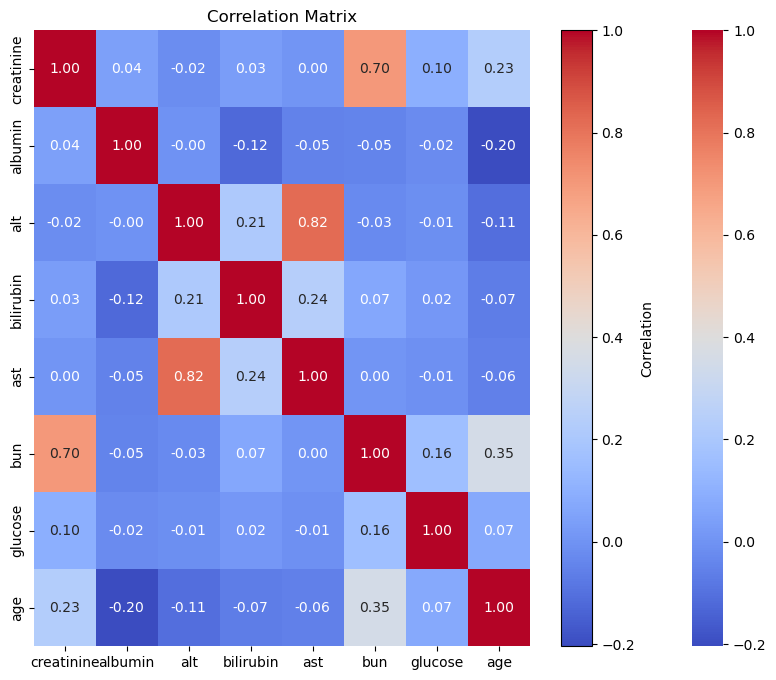

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix=X_train[numeric_features].corr()

plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f")

# Add a colorbar as a legend
cbar = plt.colorbar(heatmap.collections[0])
cbar.set_label('Correlation')

# Set the title and display the plot
plt.title('Correlation Matrix')
plt.show()

### Column transformer and preprocessor

In [22]:
from sklearn.feature_selection import RFE

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with median
    ('outlier_remover', outlier_removal),  # Remove outliers
    ('scaler', StandardScaler()),  # Scale numerical features
])


categorical_pipeline = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])




preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numeric_features),  # Apply numerical pipeline to numerical features
    ('cat', categorical_pipeline, categorical_features),  # Apply categorical pipeline to categorical features
],
  remainder='passthrough'
)


In [23]:
#X_train_prep=preprocessor.fit_transform(X_train)

In [24]:
#np.savetxt('X_train_prep.txt', X_train_prep)

In [25]:
X_train.columns

Index(['gender', 'race', 'age', 'm_ 1437702', 'm_ 1483571', 'm_ 1665021',
       'm_ 1719290', 'm_ 1745091', 'm_ 1867544', 'm_ 307675',
       ...
       'd_Z993', 'd_Z9981', 'd_Z9989', 'creatinine', 'albumin', 'alt',
       'bilirubin', 'ast', 'bun', 'glucose'],
      dtype='object', length=3782)

In [26]:
# Create pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42)) 
])
pipeline


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('outlier_remover',
                                                                   FunctionTransformer(func=<function outlier_removal at 0x000001CDBFA52D30>)),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['creatinine', 'albumin',
                                                   'alt', 'bilirubin', 'ast',
                                                   'bun', 'glucose', 'age']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'race'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

In [27]:

# Define hyperparameters for random search
param_grid = {
    'classifier__n_estimators': [100, 200, 250],
    'classifier__max_depth': [5,7,9],
   'classifier__min_samples_split': [2, 5, 10,12],
    'classifier__min_samples_leaf': [1, 2, 4],
}

from sklearn.metrics import make_scorer, average_precision_score


#pr_auc_scorer = make_scorer(average_precision_score)

random_search = RandomizedSearchCV(pipeline, 
                                   param_grid, n_iter=20,
                                   cv=StratifiedKFold(5,shuffle=True,random_state=42), 
                                   scoring='roc_auc', 
                                   refit=True,verbose=2)
random_search.fit(X_train,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   5.9s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   5.8s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   5.8s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   5.9s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=1, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   5.7s
[CV] END classifier__max_depth=7, classifier__min_samples_leaf=2, classifier__min_samples_split=12, classifier__n_estimators=250; total time=  10.0s
[CV] END classifier__max_depth=7, classifier__min

[CV] END classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   3.9s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.1s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.0s
[CV] END classifier__max_depth=5, classifier__min_samples_leaf=4, classifier__min_samples_split=5, classifier__n_estimators=100; total time=   4.0s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n_estimators=200; total time=  10.5s
[CV] END classifier__max_depth=9, classifier__min_samples_leaf=4, classifier__min_samples_split=2, classifier__n

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('outlier_remover',
                                                                                                FunctionTransformer(func=<function outlier_removal at 0x000001CDBFA52D30>)),
                                                                                               ('scaler',
                                                                                                Sta...
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['gender',
                                                                                'race'])])),
                                             ('classifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=20,
                   param_distributions={'classifier__max_depth': [5, 7, 9],
                                        'classifier__min_samples_leaf': [1, 2,
                                                                         4],
                                        'classifier__min_samples_split': [2, 5,
                                                                          10,
                                                                          12],
                                        'classifier__n_estimators': [100, 200,
                                                                     250]},
                   scoring='roc_auc', verbose=2)

In [28]:
random_search.best_params_

{'classifier__n_estimators': 250,
 'classifier__min_samples_split': 10,
 'classifier__min_samples_leaf': 1,
 'classifier__max_depth': 9}

In [29]:
cv_results = random_search.cv_results_
avg_auc_roc_score = np.mean(cv_results['mean_test_score'])
print("Average roc_auc score across cross-validations:", avg_auc_roc_score)


Average roc_auc score across cross-validations: 0.7809451058604486


In [30]:
best_estimator=random_search.best_estimator_

In [31]:
# Print the performance metrics of training

y_train_pred=best_estimator.predict(X_train)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
precision = precision_score(y_train, y_train_pred)
recall = recall_score(y_train, y_train_pred)
f1 = f1_score(y_train, y_train_pred)
roc_auc = roc_auc_score(y_train, y_train_pred)

print("Training Performance Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Training Performance Metrics:
Precision: 0.5341547773454388
Recall: 0.609822309970385
F1 Score: 0.569486056695091
ROC AUC Score: 0.732716850127571


In [32]:
# Predict the labels for the test set
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
y_pred = best_estimator.predict(X_test) 

# Calculate different performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the performance metrics
print("Test Performance Metrics:")
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)

Test Performance Metrics:
Precision: 0.48596321393998065
Recall: 0.5780080598733448
F1 Score: 0.5280042072048383
ROC AUC Score: 0.7059963700961221


In [33]:
#feature_list=X.columns.tolist()
#drop_columns=['gender', 'race','age'] 
#feature_list=[x for x in feature_list if x not in drop_columns]

In [34]:
#cat_feature_names=list(best_estimator.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out())
#Using the order in X,
#all_feature_names = cat_feature_names + ['age']+ feature_list

In [35]:
#correct 

fitted_preprocessor = random_search.best_estimator_.named_steps['preprocessor']
num_features_transformed = numeric_features
cat_features_transformed = fitted_preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
transformed_feature_names = list(num_features_transformed) + list(cat_features_transformed) + list(X_train.columns.difference(numeric_features + categorical_features))

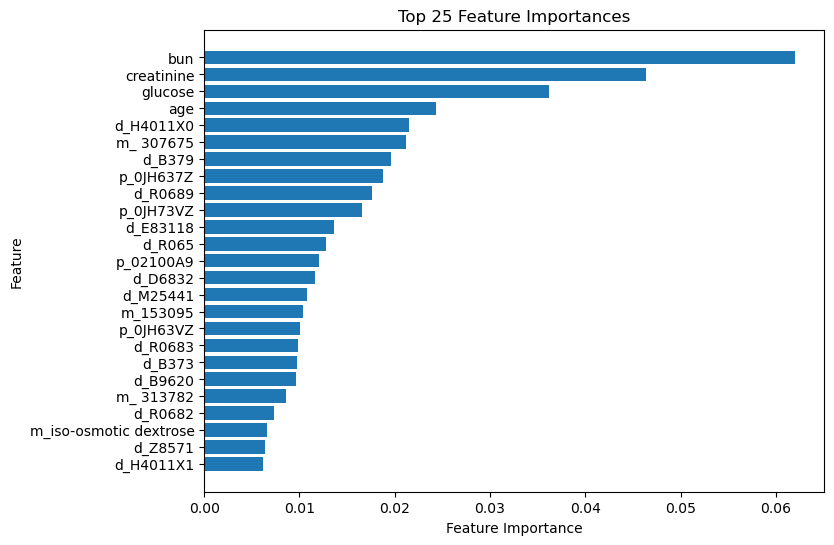

In [36]:
import matplotlib.pyplot as plt

# Assuming best_estimator is your trained Random Forest model

# Get feature importances from the Random Forest model
importances = best_estimator.named_steps['classifier'].feature_importances_

# Get feature names
feature_names = transformed_feature_names #all_feature_names

# Get indices of top 25 features
top_indices = np.argsort(importances)[::-1][:min(25, len(importances))]

# Plot feature importances
plt.figure(figsize=(8, 6))
plt.barh(range(len(top_indices)), importances[top_indices], align='center')
plt.yticks(range(len(top_indices)), [feature_names[i] for i in top_indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 25 Feature Importances')
plt.gca().invert_yaxis()  # Invert y-axis to display highest importance at the top
plt.show()

In [37]:
print([feature_names[i] for i in top_indices])

['bun', 'creatinine', 'glucose', 'age', 'd_H4011X0', 'm_ 307675', 'd_B379', 'p_0JH637Z', 'd_R0689', 'p_0JH73VZ', 'd_E83118', 'd_R065', 'p_02100A9', 'd_D6832', 'd_M25441', 'm_153095', 'p_0JH63VZ', 'd_R0683', 'd_B373', 'd_B9620', 'm_ 313782', 'd_R0682', 'm_iso-osmotic dextrose', 'd_Z8571', 'd_H4011X1']


In [38]:
#Remove patients who have no icd 10 codes ; save that to a file
#One hot encode diagnoses and procedures
#Remove any columns with less than 5% for all dfs
#Join to get a signle df  -- done

#Correlation matrxi
#Chi square test
#Remove unwanted columns

#Divide into X_train and X_test; strtify on target variable - increase_flag

#One hot encode
#Impute
#Scale numeric data
#RF with AUC-ROC - random search + hyperpaprameter ; use 5 fold CV
#get performance metrics
#
#Plot feature importance, shap values

#code to get missing %
'''

missing_percentages = round(((df9.isnull().sum() / len(df9)) * 100),2)

# Create a DataFrame to display missing percentages
missing_df = pd.DataFrame({'Missing Percentage': missing_percentages})
missing_df.index.name = 'Column'
missing_df=missing_df.reset_index()
print(missing_df)

'''

"\n\nmissing_percentages = round(((df9.isnull().sum() / len(df9)) * 100),2)\n\n# Create a DataFrame to display missing percentages\nmissing_df = pd.DataFrame({'Missing Percentage': missing_percentages})\nmissing_df.index.name = 'Column'\nmissing_df=missing_df.reset_index()\nprint(missing_df)\n\n"

### Confusion matrix

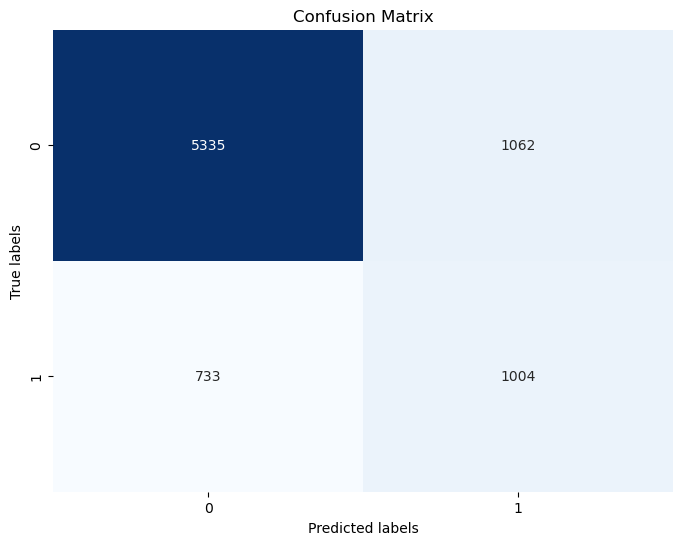

In [39]:
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

### ROC-AUC curve

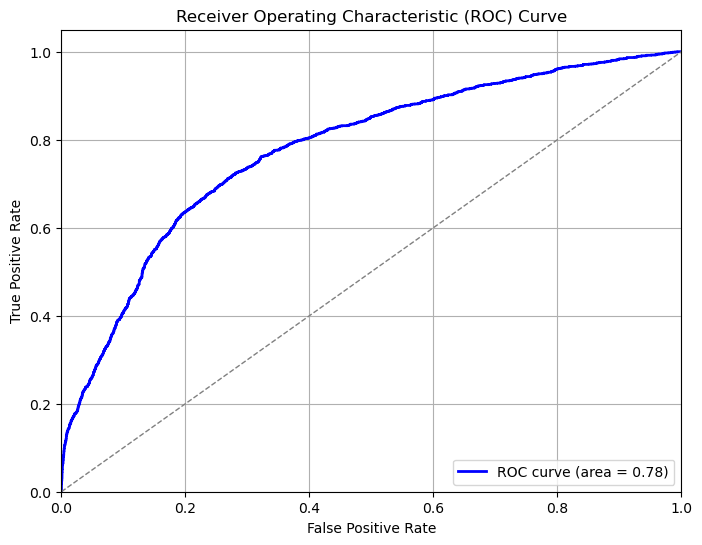

In [40]:
from sklearn.metrics import roc_curve, auc
y_prob = best_estimator.predict_proba(X_test)[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


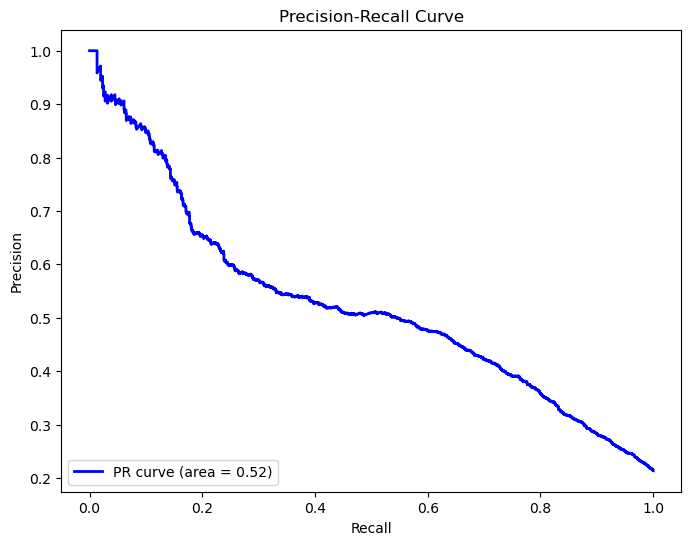

In [41]:
from sklearn.metrics import precision_recall_curve, auc
y_prob = best_estimator.predict_proba(X_test)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_prob)

# Compute PR AUC
pr_auc = auc(recall, precision)

# Plot PR curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()